# Resumo

### Cápitulo 1: Importando Dados e Primeiras Visualizações
- 1.1: Importando Dados
- 1.2: Tipos de Dados

### Cápitulo 2: Processamento de Dados
- 2.1: Limpar Comentários
- 2.2: Traduzir Comentários
- 2.3: Tratamento Finais

### Cápitulo 3: Análise de Sentimentos
- 3.1: Vader
- 3.2: Análise de Resultados

### Cápitulo 4: Análise Visual
- 4.1: Distribuição de Sentimentos
- 4.2: Análise Temporal de Comentários

# Cápitulo 1: Importando Dados e Primeiras Visualizações

### 1.1: Importando Dados

In [27]:
import pandas as pd

# Eliminate the warnings. 
import warnings
warnings.filterwarnings("ignore")

df_raw = pd.read_csv("npl_madameteia_raw.csv")

In [28]:
df_raw

,Unnamed: 0,Comentario,Nome
0,0,"Jul 3, 2024This is the most piss poor attempt ...",NaN
1,1,"Jul 2, 2024yall were overreacting this wasnt t...",NaN
2,2,"Jul 1, 2024Well, this ranks right up there wit...",George G
3,3,"Jul 1, 2024CRITICS CRITICS, MOST CRITICS DON'T...",KEVIN E
4,4,"Jul 1, 2024A film to run on TV in the backgoun...",Richard M
...,...,...,...
300977,300977,"Feb 14, 2024Me gusto la película para pasar el...",Giovanni
300978,300978,"Feb 14, 2024Oh geesh!! Was such cheesy and cri...",Julie B
300979,300979,"Feb 14, 2024just overall extremely poor, very ...",Yxng B
300980,300980,"Feb 14, 2024Worst comic book movie ever made. ...",TigerMacc


### 1.2: Tipos de Dados

In [29]:
df_raw.dtypes

Unnamed: 0     int64
Comentario    object
Nome          object
dtype: object

# Cápitulo 2: Processamento de Dados

In [30]:
df_clean = df_raw.copy()

# Remover duplicatas mantendo apenas uma ocorrência
df_clean = df_raw.drop_duplicates(subset='Comentario')

# Mostrar DataFrame sem duplicatas
print("DataFrame sem duplicatas:")
df_clean

DataFrame sem duplicatas:


,Unnamed: 0,Comentario,Nome
0,0,"Jul 3, 2024This is the most piss poor attempt ...",NaN
1,1,"Jul 2, 2024yall were overreacting this wasnt t...",NaN
2,2,"Jul 1, 2024Well, this ranks right up there wit...",George G
3,3,"Jul 1, 2024CRITICS CRITICS, MOST CRITICS DON'T...",KEVIN E
4,4,"Jul 1, 2024A film to run on TV in the backgoun...",Richard M
...,...,...,...
297537,297537,"Feb 14, 2024Me gusto la película para pasar el...",Giovanni
297538,297538,"Feb 14, 2024Oh geesh!! Was such cheesy and cri...",Julie B
297539,297539,"Feb 14, 2024just overall extremely poor, very ...",Yxng B
300980,300980,"Feb 14, 2024Worst comic book movie ever made. ...",TigerMacc


### 2.1: Limpar Comentários

In [31]:
import re

def limpar_comentario(comentario):
    # Regex para encontrar e capturar a data no início (assumindo o formato: "VerifiedJun 21, 2024" ou "Jun 21, 2024")
    data = re.search(r'^(Verified)?(\w+ \d{1,2}, \d{4})', comentario)
    
    # Se a data for encontrada, capturá-la e removê-la do comentário
    if data:
        data = data.group(2)  # Pegar apenas a parte da data, ignorando "Verified"
        # Converter a data para o formato datetime
        data = pd.to_datetime(data, format='%b %d, %Y')
        comentario = re.sub(r'^(Verified)?\w+ \d{1,2}, \d{4}', '', comentario)
    else:
        data = None
    
    # Remover "Show LessShow MoreFlag this review" no final, se presente
    comentario = re.sub(r'Show LessShow MoreFlag this review$', '', comentario)
    
    # Strip para remover espaços extras no início e no fim do comentário limpo
    comentario = comentario.strip()
    
    return data, comentario

In [32]:
# Aplicar a função à coluna 'Comentário' e criar novas colunas para data e comentário limpo
df_clean[['Data', 'Comentario']] = df_clean['Comentario'].apply(limpar_comentario).apply(pd.Series)
df_clean['Comentario_Limpo'] = df_clean['Comentario']

In [33]:
df_clean.head()

,Unnamed: 0,Comentario,Nome,Data,Comentario_Limpo
0,0,This is the most piss poor attempt at a movie ...,NaN,2024-07-03,This is the most piss poor attempt at a movie ...
1,1,yall were overreacting this wasnt that bad. no...,NaN,2024-07-02,yall were overreacting this wasnt that bad. no...
2,2,"Well, this ranks right up there with the Blue ...",George G,2024-07-01,"Well, this ranks right up there with the Blue ..."
3,3,"CRITICS CRITICS, MOST CRITICS DON'T NO HOW TO ...",KEVIN E,2024-07-01,"CRITICS CRITICS, MOST CRITICS DON'T NO HOW TO ..."
4,4,A film to run on TV in the backgound of your b...,Richard M,2024-07-01,A film to run on TV in the backgound of your b...


In [34]:
df_clean.dtypes

Unnamed: 0                   int64
Comentario                  object
Nome                        object
Data                datetime64[ns]
Comentario_Limpo            object
dtype: object

### 2.2: Traduzir Comentários

In [35]:
from googletrans import Translator
from langdetect import detect

# Instantiate translator
translator = Translator()

# List to store original and translated comments
translated_comments = []

# Function to detect language and translate to English
def traduzir_para_ingles(comentario, index):
    try:
        if detect(comentario) != 'en':
            translated_text = translator.translate(comentario, src=detect(comentario), dest='en').text
            translated_comments.append({'Index': index, 'Original': comentario, 'Translated': translated_text})
            return translated_text
        return comentario
    except:
        return comentario

In [36]:
# Apply the translation function to the 'Comentário' column safely using .loc
df_clean.loc[:, 'Comentario_Limpo'] = df_clean.apply(lambda row: traduzir_para_ingles(row['Comentario_Limpo'], row.name), axis=1)

# Create a DataFrame with the original and translated comments
df_translated = pd.DataFrame(translated_comments)

df_translated.head(10)

,Index,Original,Translated
0,8,"Un guión sin sentido, lleno de vacíos y sin lo...","A meaningless script, full of empty and withou..."
1,19,Creo que definitivamente la peor película que ...,I think that definitely the worst movie I've s...
2,48,"No entiendo el hate a esta película, la acabo ...","I don't understand the hate to this movie, I j..."
3,196,WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT...,WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT WF...
4,282,En lo personal me gustó la película aunque si ...,Personally I liked the movie although if you h...
5,284,Kan het niet helpen. Wilde graag meer websling...,Can not help.Wanted more weblingers but this w...
6,299,this movie sucks but sydeny sweeney doesnt a w...,this movie sucks but sydney sweeney doesn't a ...
7,409,"Melhor parte do filme, é quando começa os créd...","Best part of the movie, that's when the credit..."
8,548,Flat out terrible movie,Flat out terrible movie
9,557,Not very interesting.,Not very interesting.


### 2.3: Tratamentos Finais

In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from autocorrect import Speller

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
spell = Speller(lang='en')

# Define text preprocessing function
def preprocess_and_correct_text(text):
    # Remove pontuação e números
    text = re.sub(r'[\d{}]+'.format(re.escape(string.punctuation)), '', text)
    # Tokenização
    words = word_tokenize(text)
    # Remover stop words, lematizar e corrigir ortografia
    processed_words = [spell(lemmatizer.lemmatize(word.lower())) for word in words if word.lower() not in stop_words]
    # Juntar as palavras em uma string única e normalizar espaços em branco
    cleaned_text = ' '.join(processed_words).strip()
    return cleaned_text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
df_clean['Comentario_Limpo'] = df_clean['Comentario_Limpo'].apply(preprocess_and_correct_text)
df_clean

,Unnamed: 0,Comentario,Nome,Data,Comentario_Limpo
0,0,This is the most piss poor attempt at a movie ...,NaN,2024-07-03,piss poor attempt movie ’ ever seen plot line ...
1,1,yall were overreacting this wasnt that bad. no...,NaN,2024-07-02,all overheating wasnt bad amazing especially m...
2,2,"Well, this ranks right up there with the Blue ...",George G,2024-07-01,well rank right blue beetle terrible film knew...
3,3,"CRITICS CRITICS, MOST CRITICS DON'T NO HOW TO ...",KEVIN E,2024-07-01,critic critic critic dont review movie 🍿 spide...
4,4,A film to run on TV in the backgound of your b...,Richard M,2024-07-01,film run tv background bed room sleep problem ...
...,...,...,...,...,...
297537,297537,"Me gusto la película para pasar el rato, no se...",Giovanni,2024-02-14,liked movie hang good bad complies promised
297538,297538,Oh geesh!! Was such cheesy and cringey dialogu...,Julie B,2024-02-14,oh geese cheese fringe dialogue bad acting nev...
297539,297539,"just overall extremely poor, very forgettable,...",Yxng B,2024-02-14,overall extremely poor unforgettable good acto...
300980,300980,Worst comic book movie ever made. Rather watch...,TigerMacc,2024-02-14,worst comic book movie ever made rather watch ...


# Cápitulo 3: Análise de Sentimentos

### 3.1: Vader

In [39]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positivo'
    elif score['compound'] <= -0.05:
        return 'negativo'
    else:
        return 'neutro'

In [40]:
# Aplicar a função à coluna 'Comentário' e armazenar o resultado em uma nova coluna 'Sentimento'
df_clean['Sentimento'] = df_clean['Comentario_Limpo'].apply(analyze_sentiment_vader)

### 3.2: Análise de Resultados

In [41]:
# Filtrar linhas onde 'Sentimento' é 'positivo'
comentarios_negativos = df_clean[df_clean['Sentimento'] == 'positivo']

comentarios_negativos.head(10)

,Unnamed: 0,Comentario,Nome,Data,Comentario_Limpo,Sentimento
1,1,yall were overreacting this wasnt that bad. no...,NaN,2024-07-02,all overheating wasnt bad amazing especially m...,positivo
6,6,I honestly could not believe ANYONE would writ...,Stacy H,2024-06-30,honestly could believe anyone would write scri...,positivo
12,12,Is this the best movie ever made? I don’t know...,casey m,2024-06-29,best movie ever made ’ know ’ seen madame webb...,positivo
14,14,"This movie isn't as great as it should be, but...",Josh P,2024-06-27,movie isnt great bad said let get bad part way...,positivo
15,15,"The movie was okay, I was expecting more actin...",Rachel N,2024-06-27,movie okay expecting acting story line hoping ...,positivo
18,18,"Dakota has a pretty face, but she’s not the pe...",Rhee II T,2024-06-26,dakota pretty face ’ perfect actress role “ sh...,positivo
43,43,I like Nicholas Cage movies including the bad ...,Ralph G,2024-06-25,like nicholas cage movie including bad one pas...,positivo
44,44,I couldn’t even finish it! Most disappointing...,Angel D,2024-06-24,’ even finish disappointing marvel movie ever ...,positivo
45,45,Decent popcorn movie. It's not going to win an...,Efrain S,2024-06-24,decent popcorn movie going win award thought s...,positivo
46,46,With a cast that's decently talented on thier ...,Mike K,2024-06-24,cast thats recently talented thier writing hor...,positivo


In [42]:
# Filtrar linhas onde 'Sentimento' é 'negativo'
comentarios_negativos = df_clean[df_clean['Sentimento'] == 'negativo']

comentarios_negativos.head(10)

,Unnamed: 0,Comentario,Nome,Data,Comentario_Limpo,Sentimento
0,0,This is the most piss poor attempt at a movie ...,NaN,2024-07-03,piss poor attempt movie ’ ever seen plot line ...,negativo
2,2,"Well, this ranks right up there with the Blue ...",George G,2024-07-01,well rank right blue beetle terrible film knew...,negativo
3,3,"CRITICS CRITICS, MOST CRITICS DON'T NO HOW TO ...",KEVIN E,2024-07-01,critic critic critic dont review movie 🍿 spide...,negativo
4,4,A film to run on TV in the backgound of your b...,Richard M,2024-07-01,film run tv background bed room sleep problem ...,negativo
5,5,It is so bad its good because you can laugh at...,Landon M,2024-07-01,bad good laugh stupid movie,negativo
7,7,So bad it doesn’t even deserve a quarter of a ...,Marty M,2024-06-30,bad ’ even deserve quarter star,negativo
8,8,"Un guión sin sentido, lleno de vacíos y sin lo...",Daniel P,2024-06-30,meaningless script full empty without connecti...,negativo
9,9,If the CW made films on the big screen. Amazin...,Danny P,2024-06-29,cw made film big screen amazingly bad,negativo
10,10,"dull, boring and some cheesy acting.",Enzo F,2024-06-29,dull boring cheese acting,negativo
11,11,Madame Web was a major disappointment. With so...,Jose R,2024-06-29,madame web major disappointment worst writing ...,negativo


In [43]:
# Filtrar linhas onde 'Sentimento' é 'neutro'
comentarios_negativos = df_clean[df_clean['Sentimento'] == 'neutro']

comentarios_negativos.head(10)

,Unnamed: 0,Comentario,Nome,Data,Comentario_Limpo,Sentimento
52,52,"Everything in this movie happens because of ""R...",Christian M,2024-06-20,everything movie happens reason,neutro
100,100,10/10 NO COMMENT! JUST WATCH IT.,Nathaniella Alessandra M,2024-06-18,comment watch,neutro
107,107,Never watching that trash again,Sidney S,2024-06-17,never watching trash,neutro
111,111,One Hour & fifty six minutes of my life I will...,Matthew B,2024-06-16,one hour fifty six minute life never get back,neutro
190,190,Madame Web is the most unlikable lead in any s...,Jacob B,2024-06-10,madame web unlikable lead superhero movie,neutro
191,191,I usually do not rate on RT but this is the bi...,Nathaniel G,2024-06-10,usually rate rt biggest piece trash ever seen…,neutro
195,195,Wh... what tf did I just watch!?,Alexandre D,2024-06-10,wh tf watch,neutro
196,196,WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT WFT...,jordin p,2024-06-10,ft ft ft ft ft ft ft ft ft ft ft ft ft ft ft f...,neutro
198,198,Don't think of stepping in the Sony office in ...,Anthony H,2024-06-09,dont think stepping sony office caution cast d...,neutro
285,285,Reused shots from spiderman. the grenade scene...,Kenneth L,2024-06-07,reused shot sideman grenade scene embracing ai...,neutro


# Cápitulo 4: Análise Visual

### 4.1: Distribuição de Sentimentos

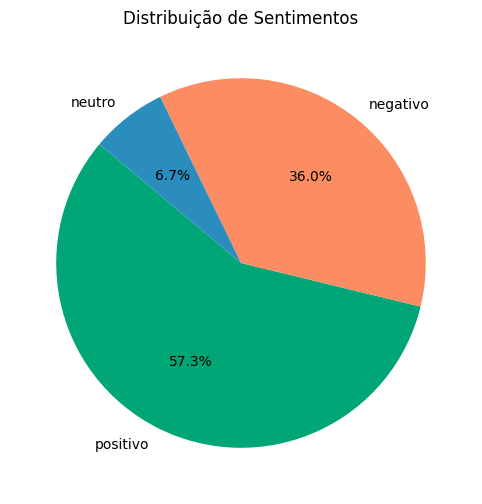

In [44]:
import matplotlib.pyplot as plt

# Conta a quantidade de cada valor na coluna 'Sentimento'
contagem_sentimentos = df_clean['Sentimento'].value_counts()

# Prepara os dados para o gráfico de pizza
labels = contagem_sentimentos.index
sizes = contagem_sentimentos.values

# Cores correspondentes aos sentimentos
cores = {
    'positivo': '#00a676',  # Verde mais escuro
    'neutro': '#2b8cbe',    # Azul mais escuro
    'negativo': '#fc8d62'   # Vermelho mais escuro
}

# Cria o gráfico de pizza
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=[cores[label] for label in labels])

# Adiciona título
plt.title('Distribuição de Sentimentos')

# Mostra o gráfico
plt.show()

### 4.2: Análise Temporal de Comentários

In [45]:
# df_clean.to_csv("npl_madameteis_clean.csv")

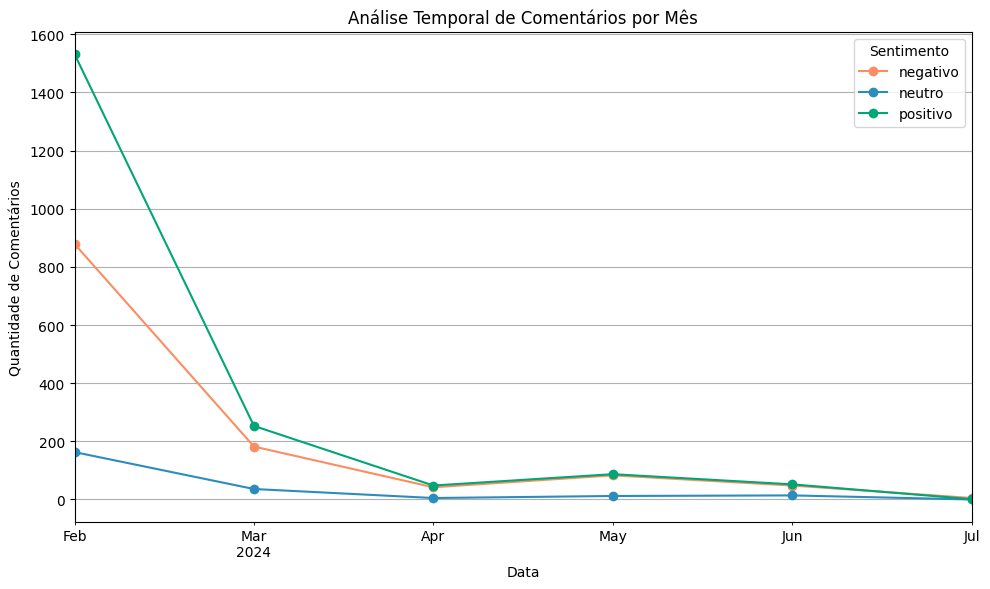

In [46]:
# Agrupar por bimestre e sentimento
comentarios_por_mes = df_clean.groupby([pd.Grouper(key='Data', freq='M'), 'Sentimento']).size().unstack(fill_value=0)

# Plotar o gráfico de linha com cores personalizadas
ax = comentarios_por_mes.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6), color=[cores.get(x, '#333333') for x in comentarios_por_mes.columns])
plt.xlabel('Data')
plt.ylabel('Quantidade de Comentários')
plt.title('Análise Temporal de Comentários por Mês')
plt.legend(title='Sentimento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

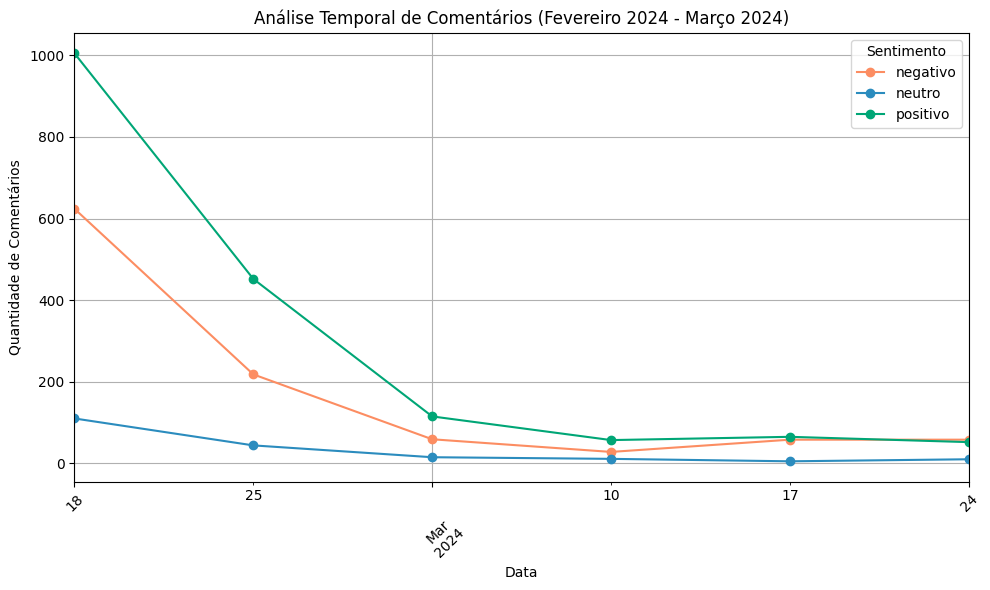

In [56]:
# Agrupar por semana e sentimento
comentarios_por_semana = df_clean.groupby([pd.Grouper(key='Data', freq='W'), 'Sentimento']).size().unstack(fill_value=0)

# Filtrar os dados de fevereiro de 2024 até abril de 2024
inicio = '2024-02-01'
fim = '2024-03-30'
filtro_periodo_1 = comentarios_por_semana.loc[inicio:fim]

# Filtrar os dados restantes
filtro_periodo_2 = pd.concat([comentarios_por_semana.loc[:inicio], comentarios_por_semana.loc[fim:]])

# Plotar o gráfico para o período de fevereiro a abril de 2024
ax1 = filtro_periodo_1.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6), color=[cores.get(x, '#333333') for x in filtro_periodo_1.columns])
plt.xlabel('Data')
plt.ylabel('Quantidade de Comentários')
plt.title('Análise Temporal de Comentários (Fevereiro 2024 - Março 2024)')
plt.legend(title='Sentimento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

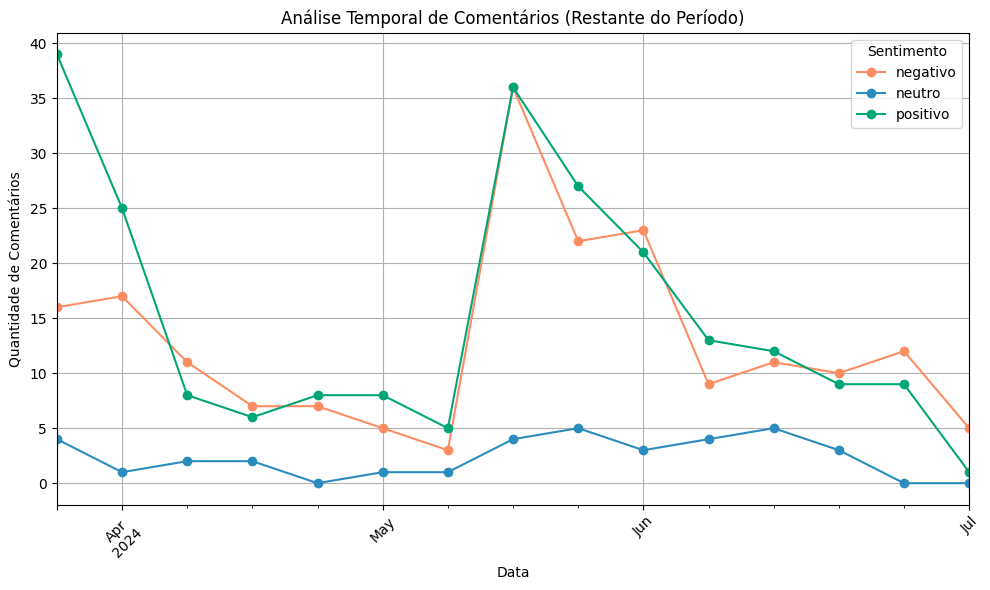

In [57]:
# Plotar o gráfico para os meses restantes
ax2 = filtro_periodo_2.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6), color=[cores.get(x, '#333333') for x in filtro_periodo_2.columns])
plt.xlabel('Data')
plt.ylabel('Quantidade de Comentários')
plt.title('Análise Temporal de Comentários (Restante do Período)')
plt.legend(title='Sentimento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()